In [1]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main'

In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main'

### Loading the dataset

In [5]:
#1. Import Necessary Liobraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm
import tensorflow as tf

import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1


from keras.optimizers import Adam
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp


import warnings
warnings.filterwarnings("ignore")


In [6]:
IMAGE_FOLDER = r"Z:\EE_297A\dataset\lanes\images"
MASK_FOLDER = r"Z:\EE_297A\dataset\lanes\masks"

In [7]:
def create_dirs_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created:", path)
    else:
        print("Directory already exists:", path)

In [8]:
create_dirs_if_not_exist(IMAGE_FOLDER)
create_dirs_if_not_exist(MASK_FOLDER)

Directory already exists: Z:\EE_297A\dataset\lanes\images
Directory already exists: Z:\EE_297A\dataset\lanes\masks


In [9]:
### Copy Images to  the Directory:
"""
This code is a data pre-processing script that goes through the TuSimple dataset’s
train_set/clips directory and copies only the 20th frame of each video clip into a single
flat folder — typically to simplify training or dataset access.
"""

CLIPS_PATH = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        clip_name = os.path.basename(os.path.dirname(frame_path))
        date_name = os.path.basename(os.path.dirname(os.path.dirname(frame_path)))
        new_filename = f"{date_name}_{clip_name}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)


Processing Clip: 0313-1
Processing Clip: 0313-2
Processing Clip: 0531
Processing Clip: 0601


In [10]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


In [11]:
# load the dataset json files
"""
Code Purpose: Load and combine TuSimple lane label JSONs
lines=True tells pandas each line is a separate JSON object (which is true for TuSimple).
Each line describes a labeled frame's lanes + metadata.
"""

df1_313 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0313.json", lines = True)
df2_531 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0531.json", lines = True)
df3_601 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0601.json", lines = True)

# combine into single dataframe
df_json = pd.concat([df1_313, df2_531, df3_601])
df_json.head()

,lanes,h_samples,raw_file
0,"[[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/6040/20.jpg
1,"[[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/5320/20.jpg
2,"[[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/23700/20.jpg
3,"[[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/51660/20.jpg
4,"[[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/25680/20.jpg


### Creating the Masks
    1. What is a mask?
    Mask: Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.
    2. Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.

In [13]:
# create function for generating masks
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((728, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane = 1, non-lane = 0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed = False, color = (255, 255, 255), thickness = 15)
    
    # generate mask filename
    raw_file_path = os.path.normpath(raw_file)  # handles / vs \ properly
    clip_name = os.path.basename(os.path.dirname(raw_file_path))     # e.g., 5160
    date_name = os.path.basename(os.path.dirname(os.path.dirname(raw_file_path)))  # e.g., 0313-1
    mask_filename = f"{date_name}_{clip_name}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [14]:
# generate masks
for index, row in tqdm(df_json.iterrows(), total=len(df_json)):
    generate_lane_mask(row)

100%|█████████████████████████████████████████████████████████████████████████████| 3626/3626 [00:22<00:00, 158.79it/s]


In [15]:
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)
    
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    # plot the image
    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    # show the images
    plt.show()

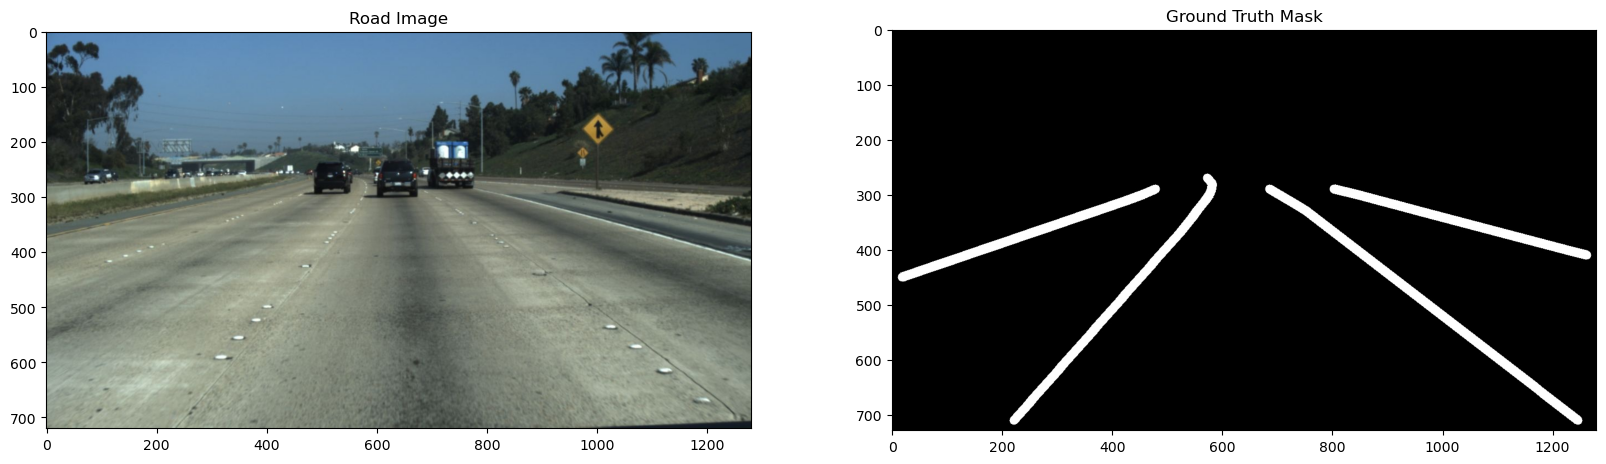

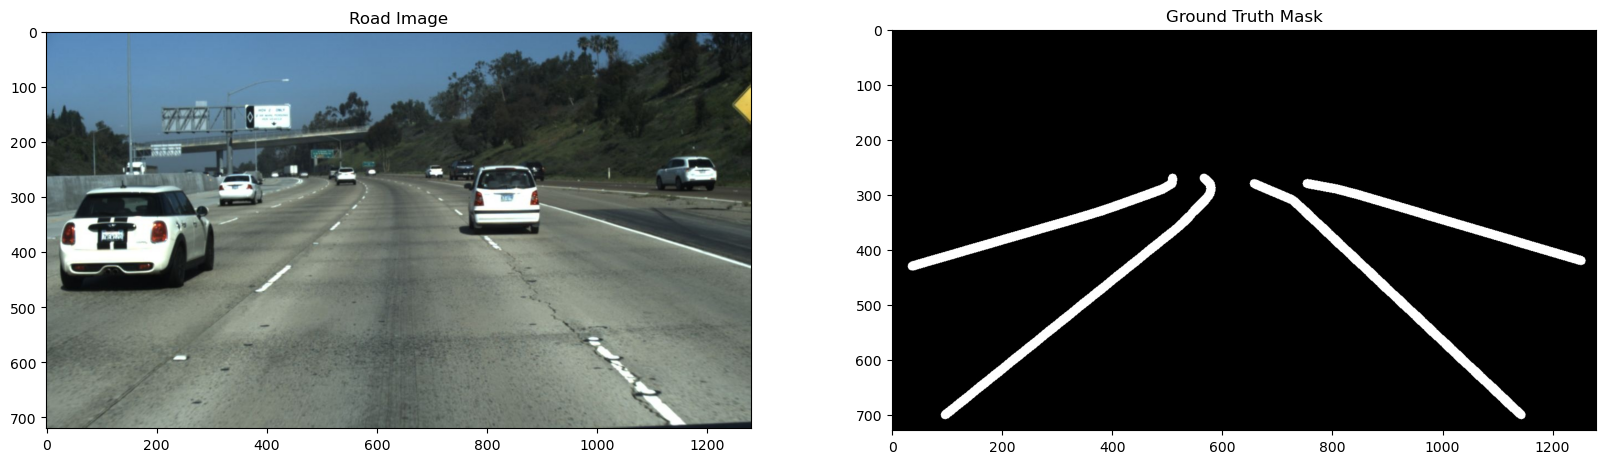

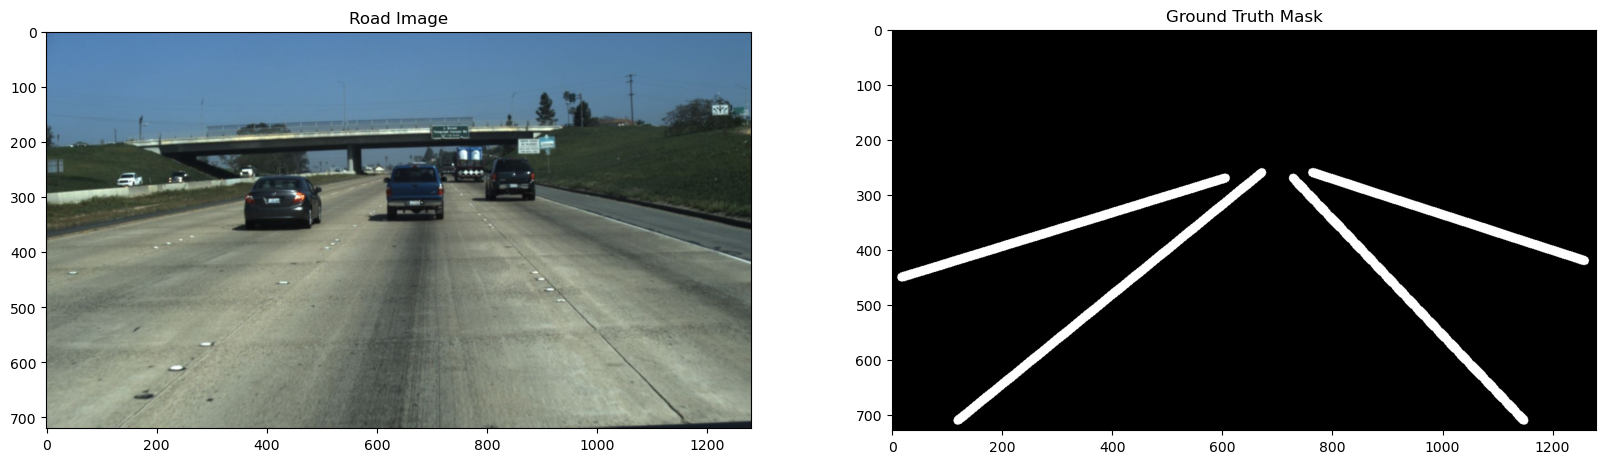

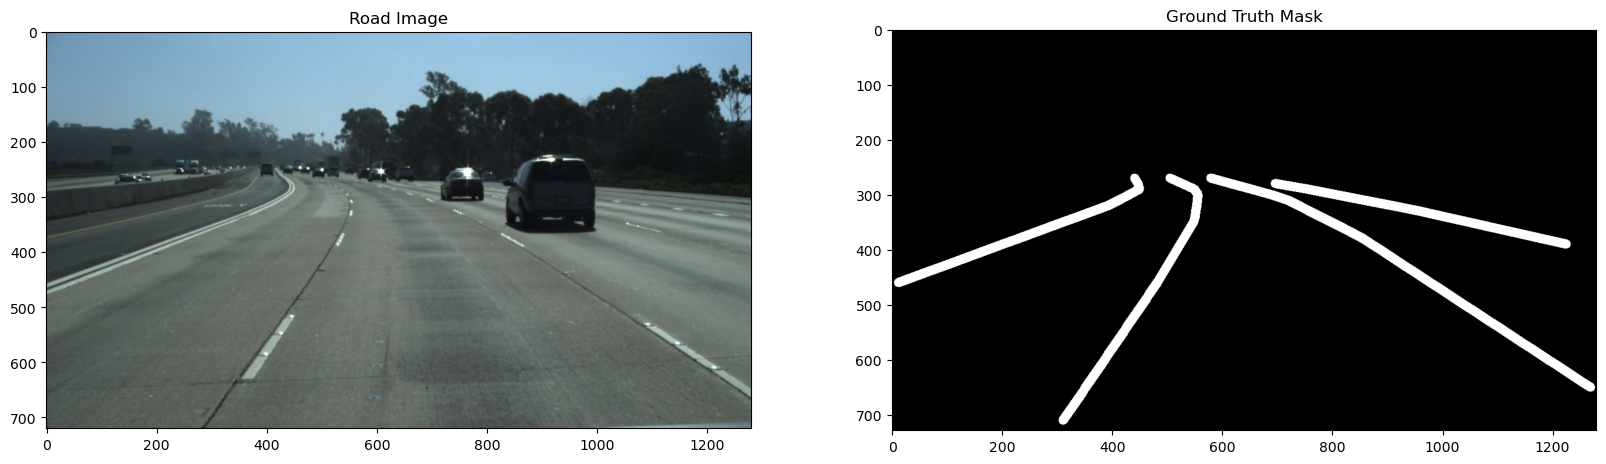

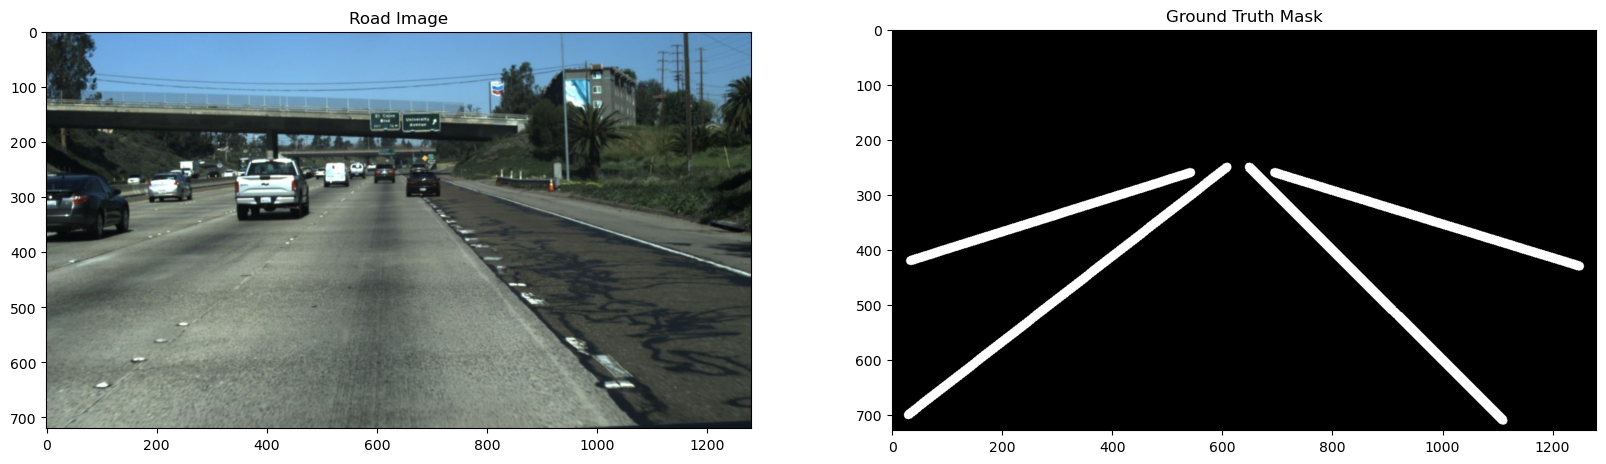

In [16]:
for i in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

In [17]:
print("Total masks in dataset:", len(os.listdir(MASK_FOLDER)))

Total masks in dataset: 3626


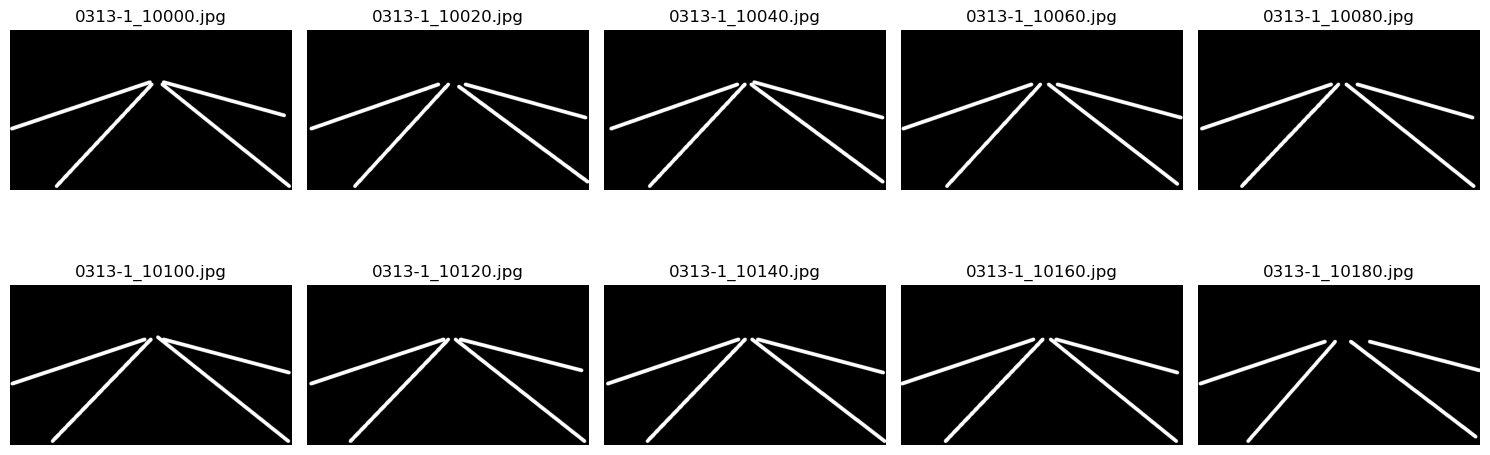

In [18]:
import os
import cv2
import matplotlib.pyplot as plt

# List all mask image files (sorted for consistency)
mask_files = sorted([
    f for f in os.listdir(MASK_FOLDER) if f.endswith(('.png', '.jpg'))
])[:10]

# Plot the first 10 masks
plt.figure(figsize=(15, 6))

for i, mask_file in enumerate(mask_files):
    mask_path = os.path.join(MASK_FOLDER, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 5, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(mask_file)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Training and Testing Splits and Processing
    1. Images
    2. Masks 

In [20]:
lane_train_image_folder = r"Z:\EE_297A\dataset\lanes\train\images"
lane_test_image_folder = r"Z:\EE_297A\dataset\lanes\test\images"
lane_train_mask_folder = r"Z:\EE_297A\dataset\lanes\train\masks"
lane_test_mask_folder = r"Z:\EE_297A\dataset\lanes\test\masks"

In [21]:
for folder_path in [lane_train_image_folder, lane_test_image_folder, lane_train_mask_folder, lane_test_mask_folder]:
    create_dirs_if_not_exist(folder_path)

Directory already exists: Z:\EE_297A\dataset\lanes\train\images
Directory already exists: Z:\EE_297A\dataset\lanes\test\images
Directory already exists: Z:\EE_297A\dataset\lanes\train\masks
Directory already exists: Z:\EE_297A\dataset\lanes\test\masks


In [201]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for train and test
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

### Feature Engineering
    What is feature engineering:
    Feature engineering is the process of creating, transforming, or selecting input variables (features) from raw data in order to improve the performance of a machine learning model.

    1. Image Loading and Preprocessing
    2. Image Sharpening Using a Convolution Kernel
    3. Mask Loading and Normalization
    4.

In [24]:
import tensorflow as tf

def load_image(image_path, mask_path):
    size = [224, 224]

    # 1. Image Loading and Preprocessing
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image / 255.0  

    # 2. Image Sharpening Using a Convolution Kernel
    kernel = tf.constant([[0., -1., 0.],
                          [-1., 5., -1.],
                          [0., -1., 0.]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])

    channels = tf.split(image, num_or_size_splits=3, axis=-1)
    sharpened_channels = []
    for c in channels:
        c_sharp = tf.nn.conv2d(tf.expand_dims(c, axis=0), kernel, strides=1, padding="SAME")
        sharpened_channels.append(tf.squeeze(c_sharp, axis=0))
    image = tf.concat(sharpened_channels, axis=-1)
    image = tf.clip_by_value(image, 0.0, 1.0)  

   # 3. Mask Loading and Normalization
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = mask / 255.0  
    
    return image, mask

In [25]:
def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(".jpg")])
    mask_files = sorted([os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith(".jpg")])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))
    
    return dataset


In [26]:
# load dataset from folder
lane_train_dataset = dataset_from_folder(lane_train_image_folder, lane_train_mask_folder)
lane_test_dataset = dataset_from_folder(lane_test_image_folder, lane_test_mask_folder)

In [27]:
"""
This code is configuring and optimizing TensorFlow tf.data.Dataset pipelines for training and testing.
 Configuration Setup
 
"""
# set config
BATCH_SIZE = 16
BUFFER_SIZE = 1000

# optimize for performance improvement
lane_train_dataset = lane_train_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
lane_train_dataset = lane_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
lane_test_dataset = lane_test_dataset.batch(BATCH_SIZE)
lane_test_datset = lane_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [28]:
def display_sample(image_list):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    titles = ["Image", "True Mask", "Predicted Mask"]
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i + 1)
        plt.title(titles[i])
        img = tf.clip_by_value(image_list[i], 0, 1)
        plt.imshow(tf.keras.utils.array_to_img(img))
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()  # ✅ free up memory

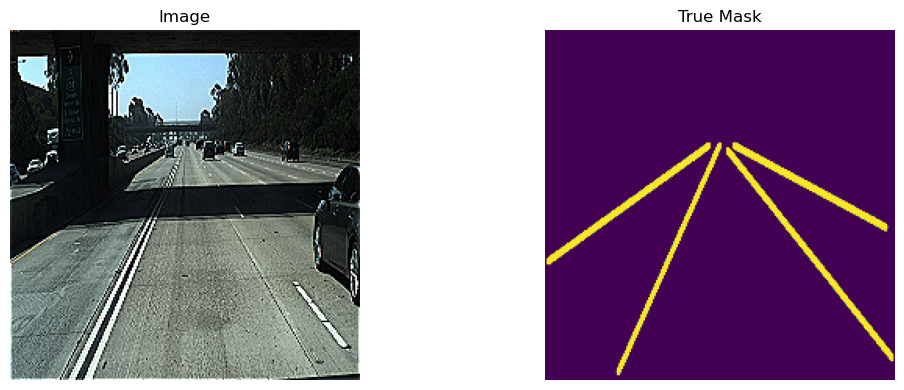

In [29]:
for image, mask in lane_train_dataset.take(1):
    display_sample([image[0], mask[0]])

In [270]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskNet, self).__init__()

        # Load pretrained ResNet18 and extract feature layers
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 7, 7)

        # Classification head
        self.class_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

        # Efficient segmentation decoder (no skip connections)
        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 7 → 14
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 14 → 28
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 28 → 56
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),    # 56 → 112
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, kernel_size=1),  # 1-channel binary mask
            nn.Upsample(size=(360, 640), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        features = self.encoder(x)

        # Classification branch
        class_out = self.class_head(features)

        # Segmentation branch
        seg_out = self.segmentation_head(features)

        return class_out, seg_out


In [272]:
model = MultiTaskNet(num_classes=10)
output_cls, output_seg = model(torch.randn(4, 3, 224, 224))  # batch of 4
print(output_cls.shape)  # -> (4, 10)
print(output_seg.shape)  # -> (4, 1, 360, 640)

torch.Size([4, 10])
torch.Size([4, 1, 360, 640])


1. Data Preparation
Creates folders for train/test images and masks

Uses train_test_split() to divide image names into 90%/10% train/val

2. TF Dataset Optimization
Adds .cache(), .shuffle(), .repeat(), .batch(), .prefetch() for training dataset

3. Visualization
Defines display_sample(...) to show image + true mask + predicted mask
Calls it on the first sample in lane_train_dataset

4. Model Definition — Switched to PyTorch
You now define MultiTaskNet using PyTorch with:

A ResNet18 encoder

A classification head

A segmentation decoder (upsampling-only, no skip connections)

Final segmentation output is upsampled to (360, 640)


5. Model Output Check
Initializes the model and runs a forward pass on random input

Confirms output shapes:

output_cls.shape → (4, 10)

output_seg.shape → (4, 1, 360, 640)

In [291]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class TuSimpleSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.file_list = file_list  # List of filenames like '0313-1_10400.jpg'
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]

        # Load image
        img_path = os.path.join(self.images_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ✅ Load mask with same .jpg extension
        mask_path = os.path.join(self.masks_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        mask = (mask > 127).astype("float32")  # Binarize

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Convert to tensors
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()
        dummy_class = torch.tensor(0)

        return img_tensor, dummy_class, mask_tensor

In [293]:
train_images_dir = lane_train_image_folder  # Z:\...\train\images
train_masks_dir  = lane_train_mask_folder
val_images_dir   = lane_test_image_folder   # Z:\...\test\images
val_masks_dir    = lane_test_mask_folder

In [295]:
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

In [297]:
# Step 2: instantiate datasets
lane_train_dataset = TuSimpleSegDataset(train_images_dir, train_masks_dir, lane_train_images)
lane_val_dataset   = TuSimpleSegDataset(val_images_dir, val_masks_dir, lane_val_images)

In [312]:
from torch.utils.data import DataLoader

lane_train_loader = DataLoader(lane_train_dataset, batch_size=16, shuffle=True)
lane_val_loader   = DataLoader(lane_val_dataset, batch_size=16, shuffle=False)

In [315]:
mask_dir = r"Z:\EE_297A\dataset\lanes\train\masks"

# List all .png files
png_files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

# Print results
if png_files:
    print(f"Found {len(png_files)} .png files in the mask folder:")
    print(png_files[:5])  # show just a few
else:
    print("✅ No .png files found in the mask folder.")

✅ No .png files found in the mask folder.


In [317]:

images_dir = r"Z:\EE_297A\dataset\lanes\train\images"  # Adjust if needed
image_filenames = os.listdir(images_dir)

# Find any .png files in the image folder
png_images = [f for f in image_filenames if f.lower().endswith(".png")]

if png_images:
    print(f"❗ Found {len(png_images)} PNG files in image folder:")
    print(png_images[:5])  # Show first few
else:
    print("✅ No PNG files found in the image folder.")

✅ No PNG files found in the image folder.


In [319]:
"""
You are training a multi-task model (MultiTaskNet) that performs:

Classification → output: out_cls

Segmentation → output: out_seg

You load:

images: shape (B, 3, H, W)

class_labels: dummy placeholder (e.g. all 0s for now)
||
masks: shape (B, 1, H, W) → this is your ground truth mask

✅ Yes — you're using masks as the ground truth for training the segmentation task.

Your model outputs:

out_cls: classification logits

out_seg: raw segmentation logits, shape (B, 1, H, W)

"""

import torch
import torch.nn as nn
from tqdm import tqdm

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskNet(num_classes=10).to(device)

criterion_cls = nn.CrossEntropyLoss()
criterion_seg = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 5

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for images, class_labels, masks in tqdm(lane_train_loader):
        images = images.to(device)
        class_labels = class_labels.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        out_cls, out_seg = model(images)

        loss_cls = criterion_cls(out_cls, class_labels)
        loss_seg = criterion_seg(out_seg, masks)
        loss = loss_cls + loss_seg

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(lane_train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # === Validation ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, class_labels, masks in lane_val_loader:
            images = images.to(device)
            class_labels = class_labels.to(device)
            masks = masks.to(device)

            out_cls, out_seg = model(images)
            loss_cls = criterion_cls(out_cls, class_labels)
            loss_seg = criterion_seg(out_seg, masks)
            val_loss += (loss_cls + loss_seg).item()

    avg_val_loss = val_loss / len(lane_val_loader)
    print(f"Val Loss: {avg_val_loss:.4f}")




Epoch 1/5


  0%|                                                                                          | 0/204 [00:11<?, ?it/s]


ValueError: Target size (torch.Size([16, 1, 728, 1280])) must be the same as input size (torch.Size([16, 1, 360, 640]))